<a href="https://colab.research.google.com/github/MatteusStranger/final_project_ia/blob/master/captcha/Captcha_maisa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">
    <h1> <b>MO416 - IC/Unicamp  </h1>
    <h2> <b>Projeto Final - Aplicação de Aprendizado de Máquina na Decifração de Captchas </h2>
</div>

<table>
<tr><td style="text-align:left">Christian Maekawa</td>  <td>231867</td>  </tr>
<tr><td style="text-align:left">Giovane de Morais</td>  <td>192683</td>  </tr>
<tr><td style="text-align:left">Maisa Silva      </td>  <td>181831</td>  </tr>
<tr><td style="text-align:left">Matteus Vargas   </td>  <td>262885</td>  </tr>
<tr><td style="text-align:left">Stéfani Fernandes</td>  <td>147939</td>  </tr>
</table>

# 1 - Introdução

A leitura de caracteres alfa-numéricos é um tarefa simples para um ser humano, porém por muitos anos esse foi um grande desafio para computadores. Nos últimos anos várias bases de dados de imagens foram utilizados em desafios para o alcance de melhor desempenho na tarefa de leitura de caracteres. Exemplos desses dataset são MNist e SVHN. 

Das abordagens aplicadas nesse objetivo estão as Redes Neurais Artificiais com várias camadas ocultas, esta abordagem é conhecida como Deep Learning. Das técnicas de Deep Learning amplamente usadas no processamento de imagens estão as Redes Neurais Convolucionais, que consideram a posição do pixel na imagem.

As Redes Neurais Convolucionais são compostas por duas grandes etapas: extração de features pelas camadas convolucionais e classificação pelas camadas finais (Pooling e Fully-Connected). Onde as camadas de convoluções alteram as representações dos dados e aprende os filtros. E a camada de Pooling reduz a escala para a próxima camada. Sendo assim cada filtro aprendido é um extrator de atributos (features) e cada imagem resultante de um filtro é um mapa de características. As camadas pooling reduzem a quantidade de características por filtro.

O objetivo desse trabalho é aplicar a abordagem de Redes Neurais Convulacionais na leitura de imagens Captchas. O dataset é impactante para o desempenho de aplicações de Aprendizado de Máquina, como nosso trabalho incluí a geração do dataset realizamos um estudo que verifica se a aplicação de critérios como permutação na geração do dataset é capaz de gerar amostras de treino que melhor representam o espaço, e assim é possível obter um 



In [1]:
##########
#
# Imports
#
##########

import os
import cv2
import string
import itertools
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix


Using TensorFlow backend.


In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !gdown --id "1mf0BxFivzVxDb11IHoYpfZLoNlHSvXvz"
  !unzip -q dataset_train_random
  !gdown --id "1aRFpq6hwCkwrsJM1wLXXrL2jxmSJ6zc7"
  !unzip -q dataset_test
  !gdown --id "1rXZGjMfMnVhhIGljkv66_Nvw4FXCG0YW"
  !unzip -q dataset_train_perm
  #!gdown --id "18pvA4cs0EKfd9ajJbqYqJxi4w77bivxh"
  #!unzip -q dataset

Downloading...
From: https://drive.google.com/uc?id=1mf0BxFivzVxDb11IHoYpfZLoNlHSvXvz
To: /content/dataset_train_random.zip
891MB [00:05, 174MB/s]
replace dataset_train_random/ON7HG.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
y
Downloading...
From: https://drive.google.com/uc?id=1aRFpq6hwCkwrsJM1wLXXrL2jxmSJ6zc7
To: /content/dataset_test.zip
178MB [00:01, 152MB/s]
replace dataset_test/TNKYD.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
y
Downloading...
From: https://drive.google.com/uc?id=1rXZGjMfMnVhhIGljkv66_Nvw4FXCG0YW
To: /content/dataset_train_perm.zip
891MB [00:06, 132MB/s]
replace dataset_train_perm/EU5E7.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
y


# 2 - Dados

Nesse trabalho geramos imagens Captcha de dimensão 60x160 com 5 caracteres, as imagens foram salvas em arquivos
.png cujo nome é a palavra contida na imagem. Foram criados 3 datasets: 

- treino aleatório: nesse dataset os 5 caracteres que formam a palavra foram escolhidos aleatoriamente 

- treino com permutação:nesse dataset 5 caracteres foram escolhidos aleatoriamente e imagens foram geradas com todas as permutações possíveis de tamanho 5. Na sequência foram escolhidos outras 5 caracteres que não haviam sido escolhidos antecipadamente. Esse ciclo foi repetido até atingir o tamanho esperado do dataset: 

- teste: foram geradas imagens com 5 caracteres escolhidos aleatoriamente.

Para reduzir o tempo de treino da RN realizamos um pré-processamento, redimensionando as imagens para 30x80 e transformando-as para escala de cinza.

In [3]:
# Símbolos presentes nos captchas
symbols = string.ascii_uppercase + "0123456789"
num_symbols = len(symbols)

print('Símbolos: ' + symbols)
print('Quantidade de símbolos: ' + str(num_symbols))

# Tamanho das imagens de entrada à RN
img_height = 30
img_width = 80
img_shape = (img_height, img_width, 1)

# Tamanho da palavra no captcha
size_word = 5

Símbolos: ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789
Quantidade de símbolos: 36


## 2.1 - Funções auxiliares para leitura dos dados
Leitura das imagens e pré-processamento para dados no formato X e Y.

In [4]:
################################################################################################################
#
# Leitura dos nomes dos arquivos
#
#    Realiza a leitura do nome dos arquivos de captchas recebendo por parametro o diretório onde os arquivos 
#    estão armazenados.
#    Retorna a lista do nome de arquivos.
#
################################################################################################################

def read_name_files(files_dir = 'dataset'):

    files = os.listdir(files_dir)
    
    return files

In [5]:
################################################################################################################
#
# Leitura das imagens em lote
#
#    Realiza a leitura das imagens captchas recebendo por parametro os símbolos que formam os captchas,
#    a lista dos nomes dos arquivos e o diretório onde os arquivos estão armazenados.
#    Retorna o dataset no formato X e y.
#
################################################################################################################

def read_dataset_batch(symbols, batch_files, captcha_dir = 'dataset'):
    
    n_samples = len(batch_files)
    
    X = np.zeros((n_samples, img_height, img_width, 1))
    y = np.zeros((size_word, n_samples, num_symbols))

    i = 0;
    
    # Leitura de cada arquivo
    for name_file in batch_files:
        
        img = cv2.imread(os.path.join(captcha_dir, name_file), cv2.IMREAD_GRAYSCALE)
        word = name_file[:-4] # retira a extensão .png
        
        # Se a palavra tem 5 caracteres
        if len(word) == size_word:
            
            img = img / 255. # Coloca o valor dos pixels entre 0 e 1
            
            # Faz o reshape da imagem para a metade do tamanho da altura e comprimento, reduzindo ela em 1/4 do tamanho
            img = cv2.resize(img, (img_width, img_height), interpolation=cv2.INTER_AREA)
            img = np.reshape(img, (img.shape[0], img.shape[1], 1))
            
            # Matriz alvo, possui numero da caracteres na palavra por número de caracteres possíveis
            # Na matriz alvo se a posição corresponde a determinado símbolo o valor da célula será 1, 
            # e 0 caso contrário.
            targs = np.zeros((size_word, num_symbols))
            
            for idx_letter, simbol in enumerate(word):
                n_simbol = symbols.find(simbol)
                targs[idx_letter, n_simbol] = 1
                
            X[i] = img
            y[:, i] = targs
            
            i = i +1;
            
            # Controle de progresso
            if(i%10000 == 0):
                print(str(i) + " imagens read");

    return X, y

## 2.2 - Datasets 

Leitura dos nomes de arquivos dos datasets de treino e leitura do dataset de teste que é único e imutável.

In [6]:
name_dir_random = 'dataset_train_random';
name_captcha_files_rand = read_name_files(files_dir = 'dataset_train_random')
print('Número de imagens no dataset randômico: ' + str(len(name_captcha_files_rand)))
X_train_random, y_train_random = read_dataset_batch(symbols, name_captcha_files_rand, captcha_dir = name_dir_random)

Número de imagens no dataset randômico: 99910
10000 imagens read
20000 imagens read
30000 imagens read
40000 imagens read
50000 imagens read
60000 imagens read
70000 imagens read
80000 imagens read
90000 imagens read


In [7]:
name_dir_perm = 'dataset_train_perm';
name_captcha_files_perm = read_name_files(files_dir = 'dataset_train_perm')
print('Número de imagens no dataset permutação: ' + str(len(name_captcha_files_perm)))
X_train_perm, y_train_perm = read_dataset_batch(symbols, name_captcha_files_perm, captcha_dir = name_dir_perm)

Número de imagens no dataset permutação: 100029
10000 imagens read
20000 imagens read
30000 imagens read
40000 imagens read
50000 imagens read
60000 imagens read
70000 imagens read
80000 imagens read
90000 imagens read
100000 imagens read


In [8]:
name_dir_test = 'dataset_test';
name_captcha_files_test = read_name_files(files_dir = name_dir_test)
print('Número de imagens no dataset teste: ' + str(len(name_captcha_files_test)))

X_test, y_test = read_dataset_batch(symbols, name_captcha_files_test, captcha_dir = name_dir_test)


Número de imagens no dataset teste: 19976
10000 imagens read


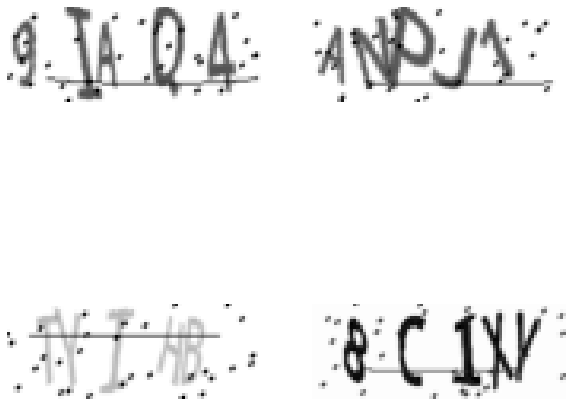

In [9]:
# Exemplo de imagem
fig, axs = plt.subplots(2,2,figsize=(10,10))
    
j = 0
k = 0
for i in (10, 100, 1000, 10000):        
    img = X_test[i,:,:]
    img.shape = (30,80)        
    axs[j%2][k%2].imshow(img, cmap='gray')
    axs[j%2][k%2].axis('off')
    k = (j - 1 < 1)
    j = j + 1

plt.show()

# 3 - Modelo

Nesse trabalho implementamos Redes Neurais Convulacionais (CNN). A CNN já tem embutida em  si características que favorecem o aprendizado de imagens. Elas forçam a extração de características de forma localizada, o que explora o fato de ser benéfico a composição de características locais antes de reconhecer objetos em uma imagem.

As CNNs combinam três conceitos: local receptive fields, weight sharing e spatial sub-sampling (pooling).
Em uma aplicação típica de redes convolucionais a entrada será uma imagem. Cada unidade da camada convolucional receberá como entrada um conjunto de unidades da camada anterior, localizadas na mesma vizinhança. Esse conjunto de unidades que atua como input para a próxima camada é chamado de local receptive fields. Utilizando esse conjunto de variáveis os neurônios podem extrair características básicas da imagem como arestas ou vértices. Em camadas posteriores os neurônios estão indiretamente ligados a todos os pixels. Nessas camadas eles detectarão características mais complexas, que são composições das características mais básicas.

Como a extração de características pode ser útil em toda a imagem, a convolução força as unidades a terem o mesmo conjunto de pesos (weights sharing). As unidades de uma camada são organizadas em planos chamados de feature map. As unidades em um feature map extraem a mesma característica em diversos pontos da imagem.  Uma camada convolucional podem conter diversos feature maps sendo que cada um possuirá um conjunto de pesos compartilhados e reconhecerá um padrão ou característica diferente.

Uma vez que uma unidade tenha reconhecido uma característica sua posição absoluta se torna menos importante. O importante é sua posição relativa em relação aos outro padrões da imagem. Dessa forma, é relevante que a rede neural tenha uma certa resistência à traslados e distorções das entradas. Uma forma de se reduzir a precisão com que as características são inseridas em um feature map é reduzindo sua resolução, o que reduz a sensibilidade em relação a variações de posição. A forma mais comum de se implementar essa invariância é adicionando uma camada de pooling.

Pooling é uma função que reduz ou resume uma  entrada utilizando alguma métrica. Algumas métricas são: pegar dentro de uma vizinhança a entrada máxima (max pooling), fazer a média das entradas (average pooling), obter a norma L2 das entradas ou tirar a média harmônica baseada na distância ao pixel central. 


## 3.1 - Rede Neural

In [10]:
################################################################################################################
#
# Modelo
#
#    Geração da rede neural com base no Keras
#
################################################################################################################

def create_net():
    
    img = layers.Input(shape=img_shape) 
    
    # Convolução
    conv1 = layers.Conv2D(16, (3, 3), padding='valid', activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', name='Conv_1')(img)    
    mp1 = layers.MaxPooling2D(padding='same', name='MaxPool_1')(conv1)
    
    # Convolução
    conv2 = layers.Conv2D(32, (3, 3), padding='valid', activation='relu', use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros', name='Conv_2')(mp1)
    mp2 = layers.MaxPooling2D(padding='same', name='MaxPool_2')(conv2)
    
    # Convolução
    conv3 = layers.Conv2D(32, (3, 3), padding='valid', activation='relu', use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros', name='Conv_3')(mp2)
    bn = layers.BatchNormalization()(conv3)
    
    # Camada de saída
    mp3 = layers.MaxPooling2D(padding='same', name='MaxPool_3')(bn) 
    flat = layers.Flatten()(mp3)
    
    outs = []
    for i in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, name='digit%d' % i, activation='sigmoid')(drop)

        outs.append(res)
    
    model = Model(img, outs)
    model.compile('adam', loss=['categorical_crossentropy', 'categorical_crossentropy',
                                   'categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], metrics=['accuracy'])
    model.summary()
    return model


## 3.2 - Funções auxiliares

In [11]:
################################################################################################################
#
# Variáveis Globais do Treino, tanto parametros de entrada
#
################################################################################################################

n_epoch = 500
size_batch_train = 10000
validation_split=0.2
size_batch_files = 101000

In [12]:
################################################################################################################
#
# Plot History
#
#    Plota os gráficos das métricas do treino, acurácia e erro do modelo e de cada digito.
#
################################################################################################################


def plot_model_history(history):
    
    # Variáveis globais que armazenam os valores unificados
    global digit_acc, val_digit_acc, loss, val_loss    
    
    # Acurácia modelo
    acc = np.sum([history.history['digit%d_accuracy' % i] for i in range(5)], axis=0)/5;
    val_acc = np.sum([history.history['val_digit%d_accuracy' % i] for i in range(5)], axis=0)/5;

    # Gráficos    
    fig, axs = plt.subplots(2,2,figsize=(20,20))
    
    # Acurácia dos Digitos    
    for i in range(5):
        axs[1][0].plot(history.history['digit' + str(i)+ '_accuracy'], label='digit%d_accuracy' % i)
        axs[1][0].plot(history.history['val_digit%d_accuracy' % i], label='val_digit%d_accuracy' % i)    
    axs[1][0].set_title('Digit Accur')
    axs[1][0].set_ylabel('Accur')
    axs[1][0].set_xlabel('Epoch')
    #axs[1][0].set_xticks(np.arange(1,len(digit_acc[0])+1),len(digit_acc[0])/10)
    axs[1][0].legend()
    
    # Erro dos Digitos    
    for i in range(5):
        axs[1][1].plot(history.history['digit' + str(i) + '_loss'], label='digit%d_loss' % i)
        axs[1][1].plot(history.history['val_digit' + str(i) + '_loss'], label='val_digit%d_loss' % i)
    axs[1][1].set_title('Digit Loss')
    axs[1][1].set_ylabel('Accur')
    axs[1][1].set_xlabel('Epoch')
    #axs[1][1].set_xticks(np.arange(1,len(digit_loss[0])+1),len(digit_loss[0])/10)
    axs[1][1].legend()

    # Acurácia do Modelo
    axs[0][0].plot(range(1,len(acc)+1),acc, label='treino')
    axs[0][0].plot(range(1,len(val_acc)+1),val_acc, label='validation')
    axs[0][0].set_title('Model Accur')
    axs[0][0].set_ylabel('Accur')
    axs[0][0].set_xlabel('Epoch')
    #axs[0][0].set_xticks(np.arange(1,len(acc)+1),len(acc)/10)
    axs[0][0].legend()
    
    # Erro do Modelo
    axs[0][1].plot(range(1,len(history.history['loss'])+1),history.history['loss'], label='treino')
    axs[0][1].plot(range(1,len(history.history['val_loss'])+1),history.history['val_loss'], label='validation')
    axs[0][1].set_title('Model Loss')
    axs[0][1].set_ylabel('Loss')
    axs[0][1].set_xlabel('Epoch')
    #axs[0][1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[0][1].legend()
    
    
    
    plt.show()

In [13]:
################################################################################################################
#
# Salva Pesos
#
#    Criação de função de callback para salvar os pesos da Rede Neural
#    As informações são concatenas em variáveis globais, por isso não é necessário retorno.
#    O arquivo salvo é nomeado com a época e o erro.
#
################################################################################################################

outputFolder = './output-captcha'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
    
filepath=outputFolder+"/weights-{epoch:02d}-{loss:.2f}.hdf5"
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=200)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, \
                             mode='auto', period=100)
callbacks_list = [earlystop,checkpoint]



# 4 - Treino

## 4.1 - Treino de Dataset aleatório

In [14]:
net_random = create_net()
history_random = net_random.fit(X_train_random, [y_train_random[0], y_train_random[1], y_train_random[2], y_train_random[3], y_train_random[4]], epochs=n_epoch, validation_split=validation_split, batch_size=size_batch_train, callbacks=callbacks_list)



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 80, 1)    0                                            
__________________________________________________________________________________________________
Conv_1 (Conv2D)                 (None, 28, 78, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
MaxPool_1 (MaxPooling2D)        (None, 14, 39, 16)   0           Conv_1[0][0]                     
__________________________________________________________________________________________________
Conv_2 (Conv2D)                 (None, 12, 37, 32)   4640        MaxPool_1[0][0]                  
____________________________________________________________________________________________

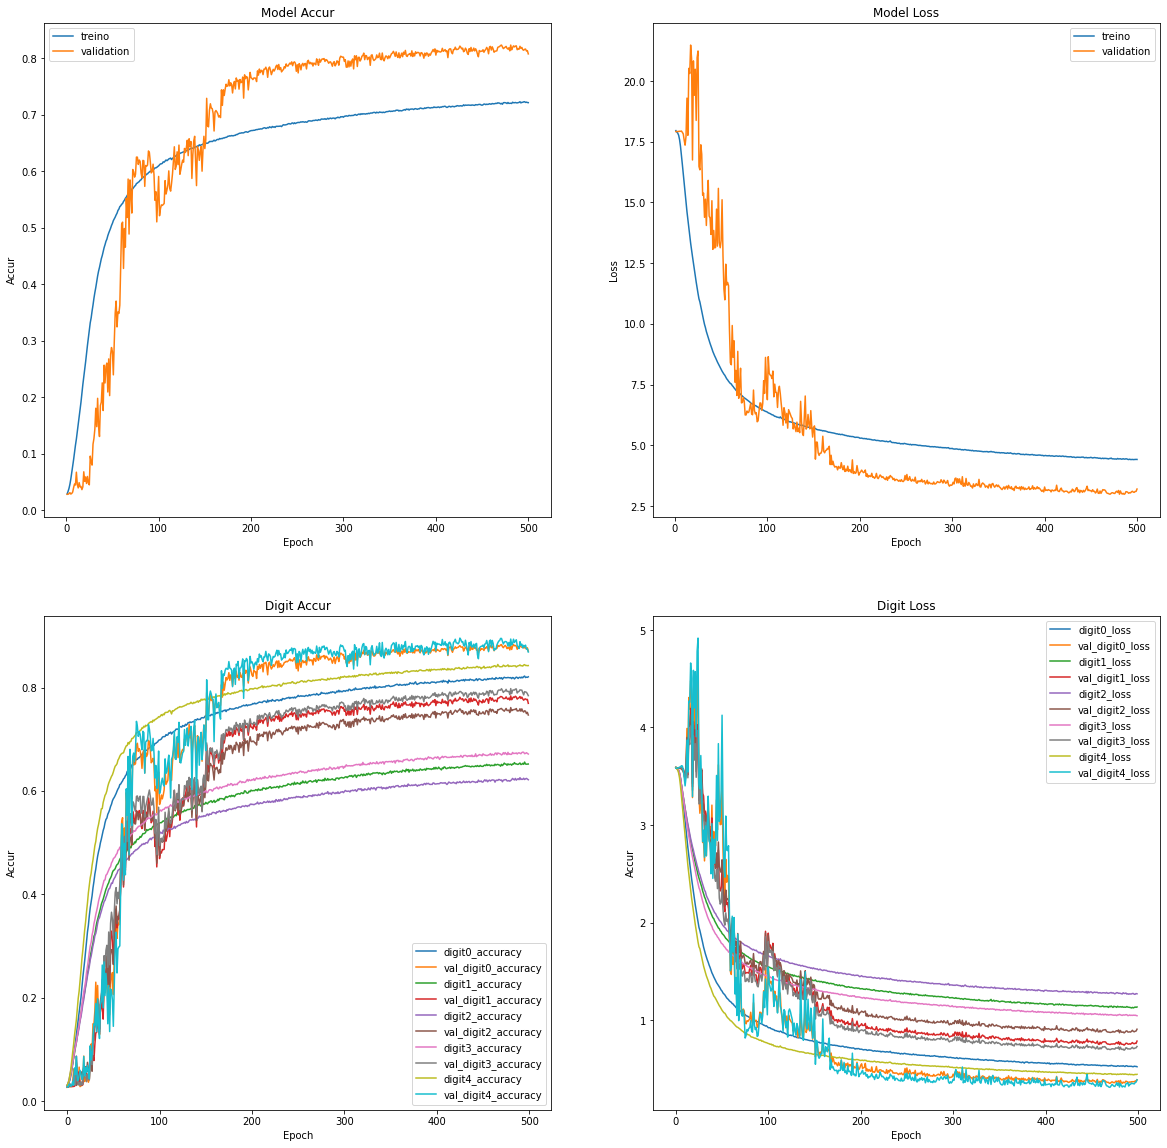

In [15]:
plot_model_history(history_random)

## 4.2 - Treino Dataset Permut

In [16]:
net_perm = create_net();
history_perm = net_perm.fit(X_train_perm, [y_train_perm[0], y_train_perm[1], y_train_perm[2], y_train_perm[3], y_train_perm[4]], epochs=n_epoch, validation_split=validation_split, batch_size=size_batch_train, callbacks=callbacks_list)
  

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 30, 80, 1)    0                                            
__________________________________________________________________________________________________
Conv_1 (Conv2D)                 (None, 28, 78, 16)   160         input_2[0][0]                    
__________________________________________________________________________________________________
MaxPool_1 (MaxPooling2D)        (None, 14, 39, 16)   0           Conv_1[0][0]                     
__________________________________________________________________________________________________
Conv_2 (Conv2D)                 (None, 12, 37, 32)   4640        MaxPool_1[0][0]                  
____________________________________________________________________________________________

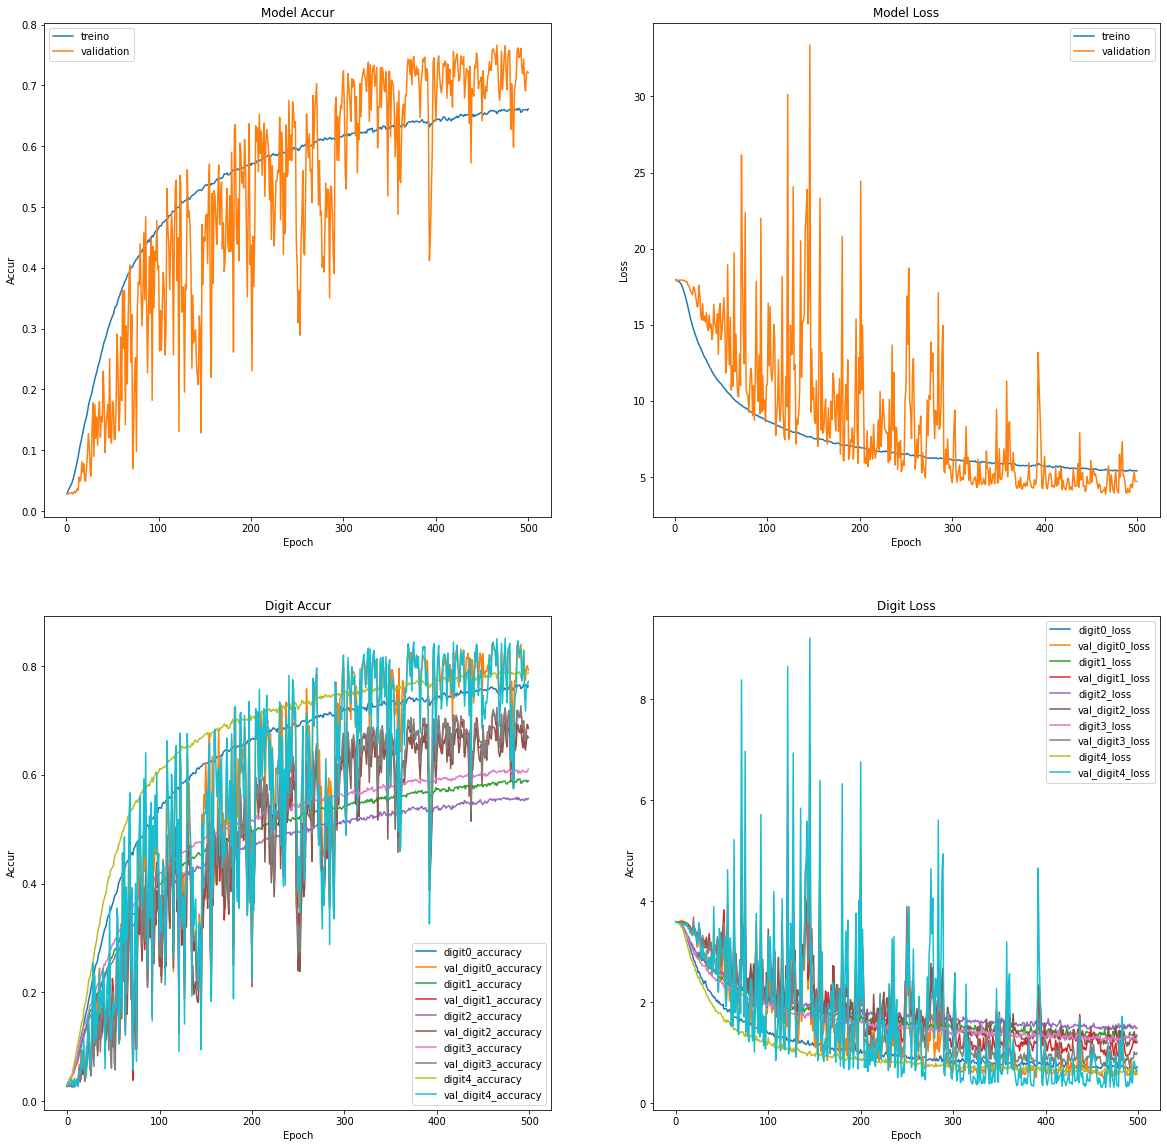

In [17]:
plot_model_history(history_perm)

# 5 - Teste

## 5.1 - Funções auxiliares

In [18]:
################################################################################################################
#
# Predição
#
#    Função que recebe um modelo e uma imagem captcha e retorna a string contida nela conforme determinado pelo
#    modelo.
#
################################################################################################################

def predict(net, img):
    
    word_predicted = np.array(net.predict(img[np.newaxis, :, :, np.newaxis]))
    word_predicted = np.reshape(word_predicted, (size_word, num_symbols))
    
    capt = ''
    for symbol in word_predicted:
        idx_symbol = np.argmax(symbol)
        capt += symbols[idx_symbol]
    
    return capt

In [19]:
################################################################################################################
#
# Plota Matriz de Confusão
#
#    Plota a Matriz de confunsão das classes reais vs as preditas
#
################################################################################################################

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
        
    #print(cm)

    plt.figure(figsize = (15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes, rotation=45)    
    plt.yticks(tick_marks, classes)

    plt.tick_params(axis='both', which='major')
    plt.tick_params(axis='both', which='minor')
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [20]:
################################################################################################################
#
# Métricas
#
#    Plota a Matriz de confunsão e retorna as métricas de acurácia.
#
################################################################################################################

def metrics(x, y, model):
    
    # Estatísticas
    # index 5 = matriz total, de todos os digitos.
    confusion_digit_predict = [[] for _ in range(6)]
    confusion_digit_true = [[] for _ in range(6)]

    y_d = np.array(y)    
    y_d = np.argmax(y, axis=2);    
    d_num_correct = [0, 0, 0, 0, 0]
    #print(x.shape);
    #print(x[0].shape);
    for i in range(x.shape[0]):
        capt = predict(model, x[i,:,:,0])        
        
        for j in range(size_word):
            d_num_correct[j] = d_num_correct[j] + np.sum(capt[j] == symbols[y_d[j][i]])
            confusion_digit_predict[j].extend(capt[j]);
            confusion_digit_true[j].extend(symbols[y_d[j][i]]);
            #Geral
            confusion_digit_predict[5].extend(capt[j]);
            confusion_digit_true[5].extend(symbols[y_d[j][i]]);
    
    # Plota matizes de confusion:
    for j in range(size_word):
        plot_confusion_matrix(confusion_matrix(confusion_digit_predict[j], confusion_digit_true[j]), symbols, title='Confusion matrix D'+str(j))
    
    # Matrix geral
    plot_confusion_matrix(confusion_matrix(confusion_digit_predict[5], confusion_digit_true[5]), symbols, title='Confusion matrix Geral')
    
    num_samples = x.shape[0];
    num_caracteres = len(capt)*num_samples;
    num_correct = np.sum(d_num_correct);
    
    d_accuracy = np.array(d_num_correct)/num_samples
    accuracy = float(num_correct)/num_caracteres
    
    #plot_confusion_matrix(confusion_matrix(true_class, predicted_class), className)
    
    return accuracy, d_accuracy

In [21]:
################################################################################################################
#
# Amostras de Predição
#
################################################################################################################
def predict_sample(net):
    
    fig, axs = plt.subplots(2,2,figsize=(10,10))
    
    j = 0
    k = 0
    for i in (10, 100, 1000, 10000):        
        img = X_test[i,:,:]
        img.shape = (30,80)    
        axs[j%2][k%3].imshow(img, cmap='gray')
        
        word = predict(net,img)
        axs[j%2][k%2].set_title(word)
        
        k = (j - 1 < 1)
        j = j + 1
    
    plt.axis('off')    
    plt.show()

## 5.2 - Experimentos

### 5.2.1 - Modelo randômico

In [22]:
################################################################################################################
#
# Avalia modelo randomico
#
################################################################################################################

net_random.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])


19976/19976 [==============================] - 5s 249us/step


[3.218974897180694,
 0.416611909866333,
 0.7856122851371765,
 0.8966253995895386,
 0.7258896827697754,
 0.39359501004219055,
 0.8663896918296814,
 0.7711253762245178,
 0.7493492364883423,
 0.7863436341285706,
 0.8681918382644653]

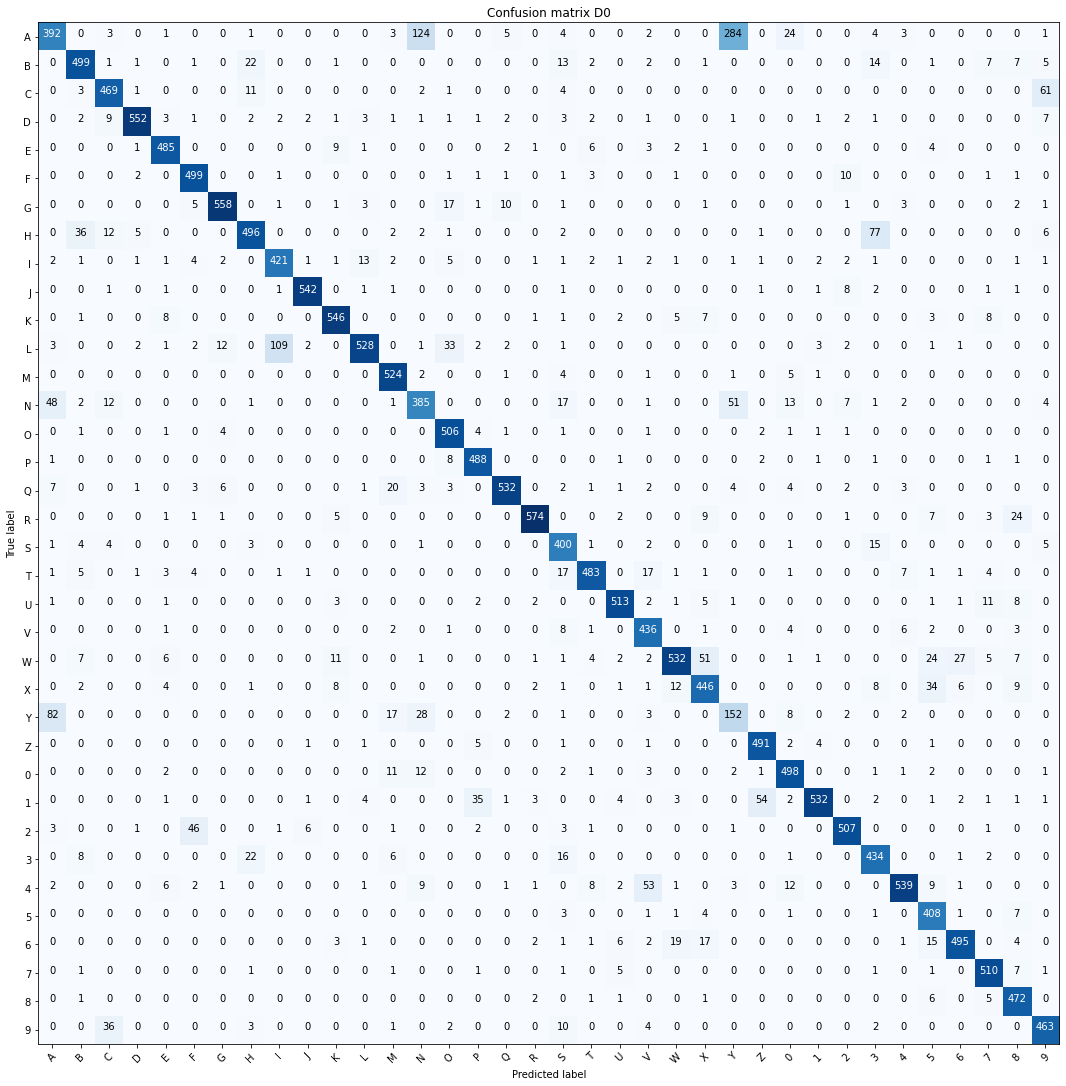

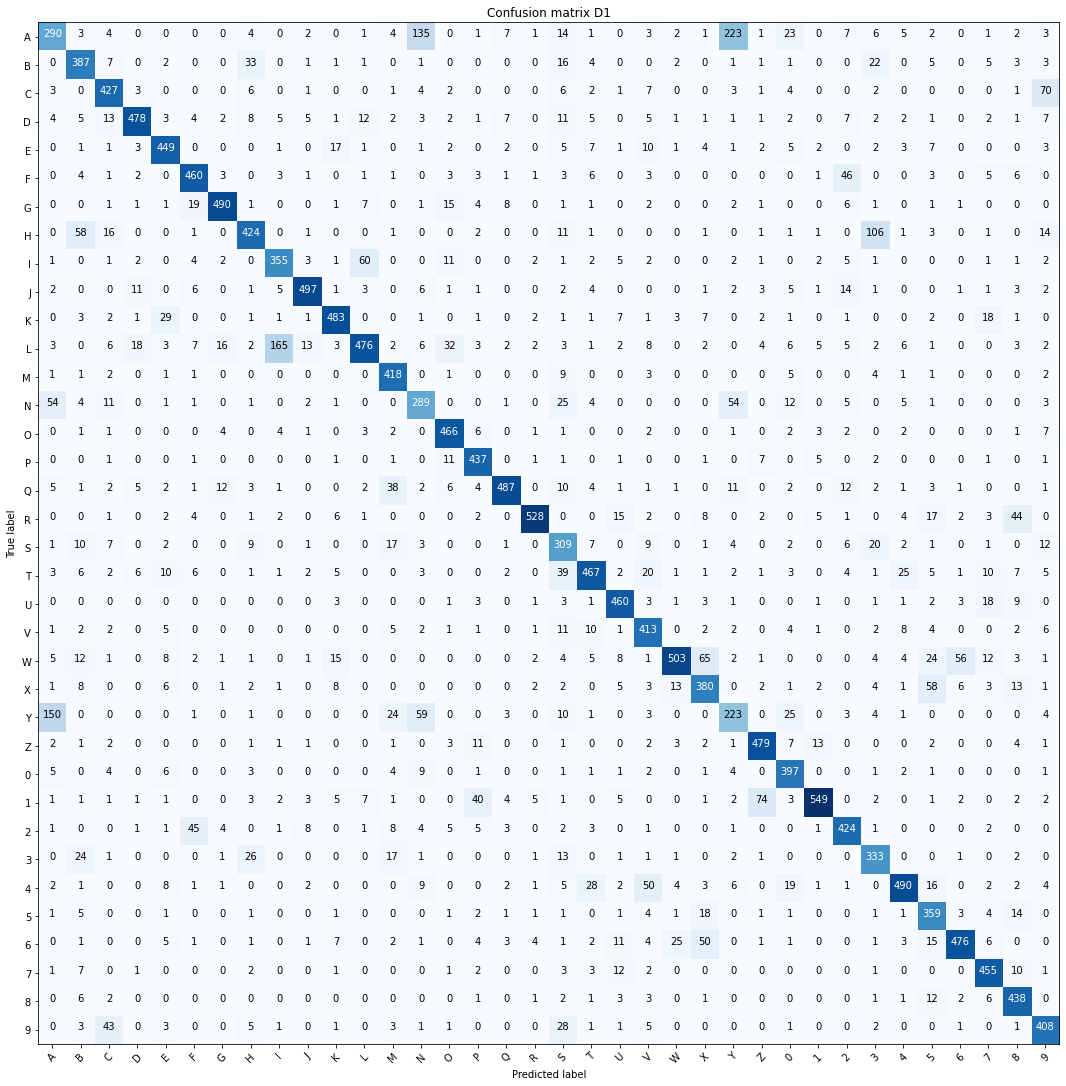

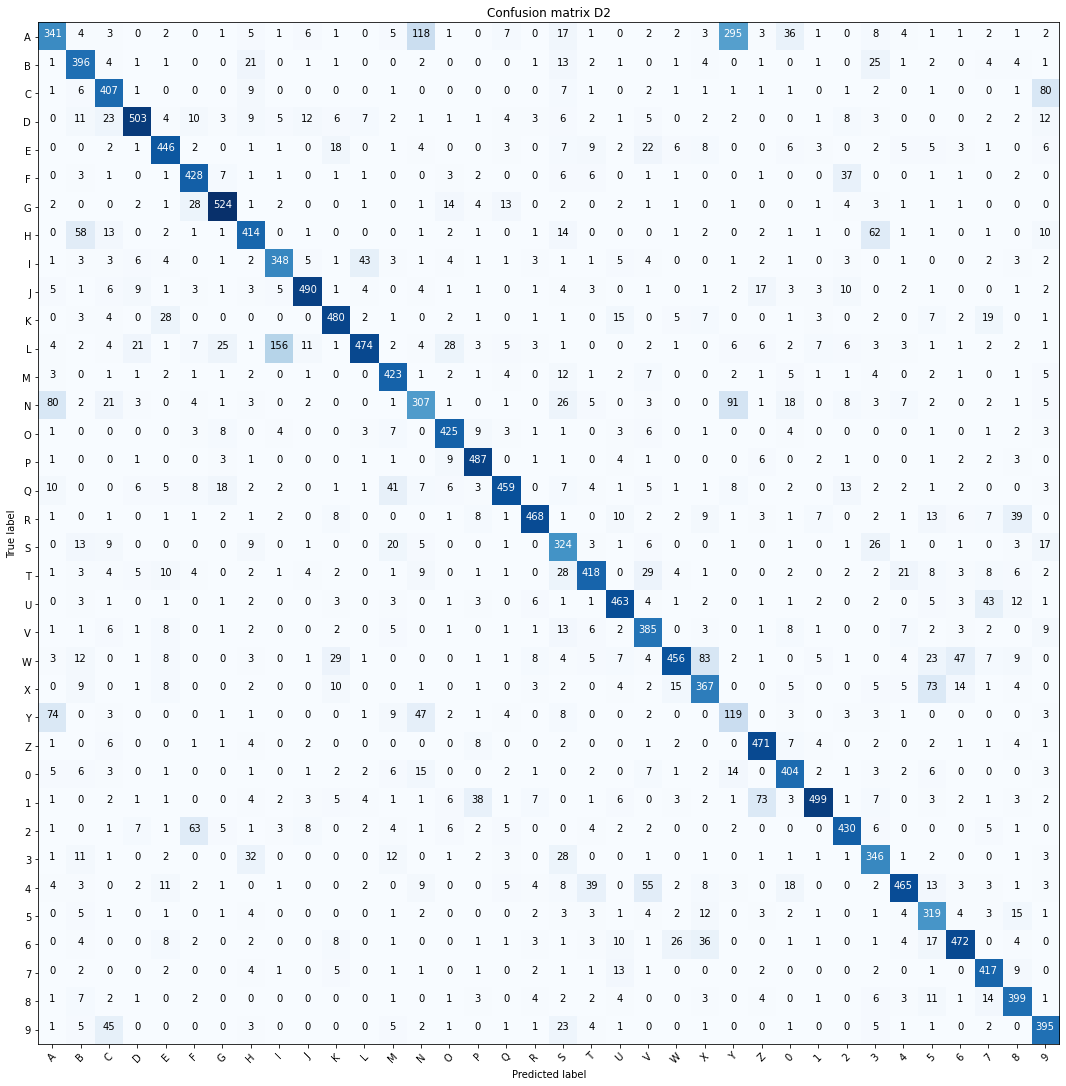

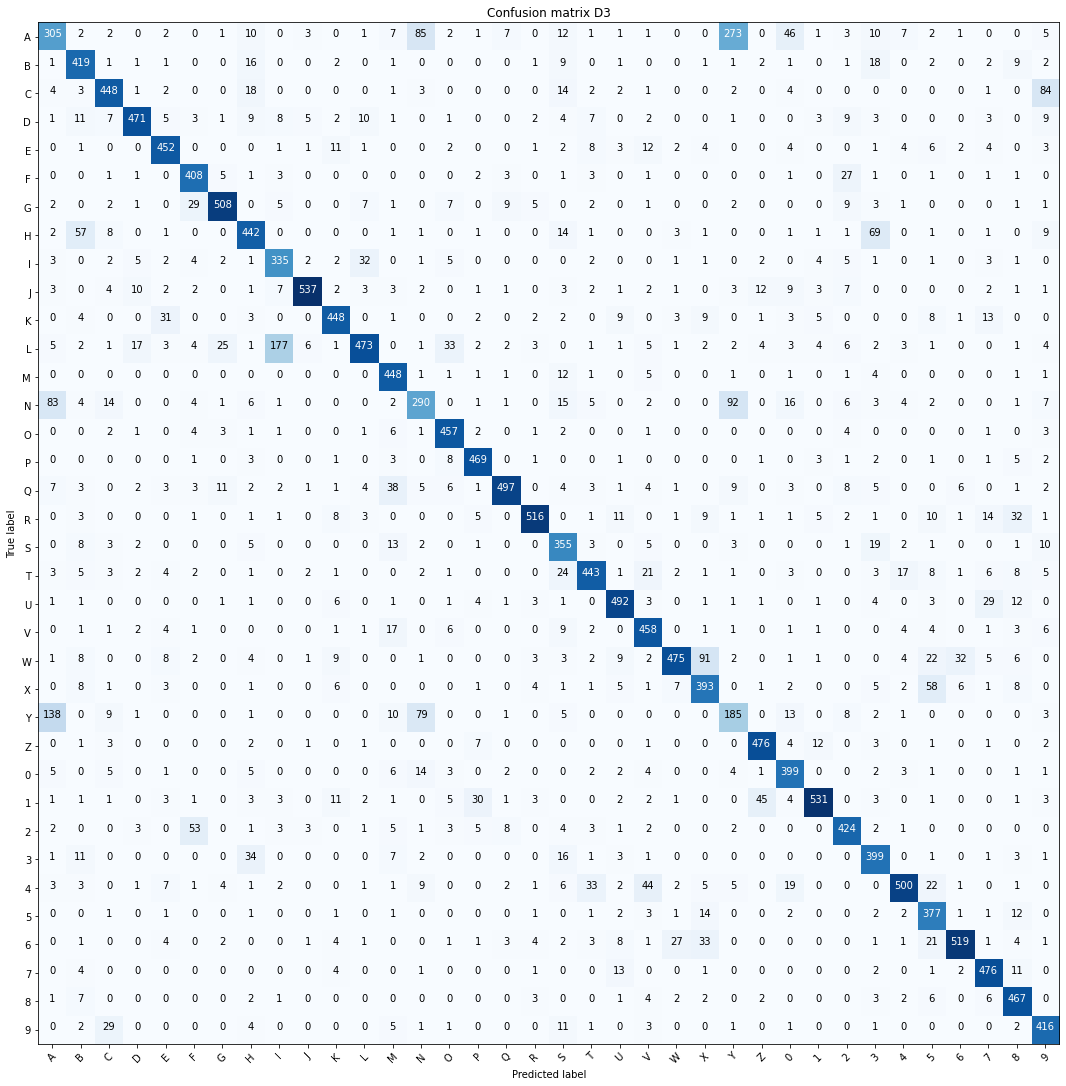

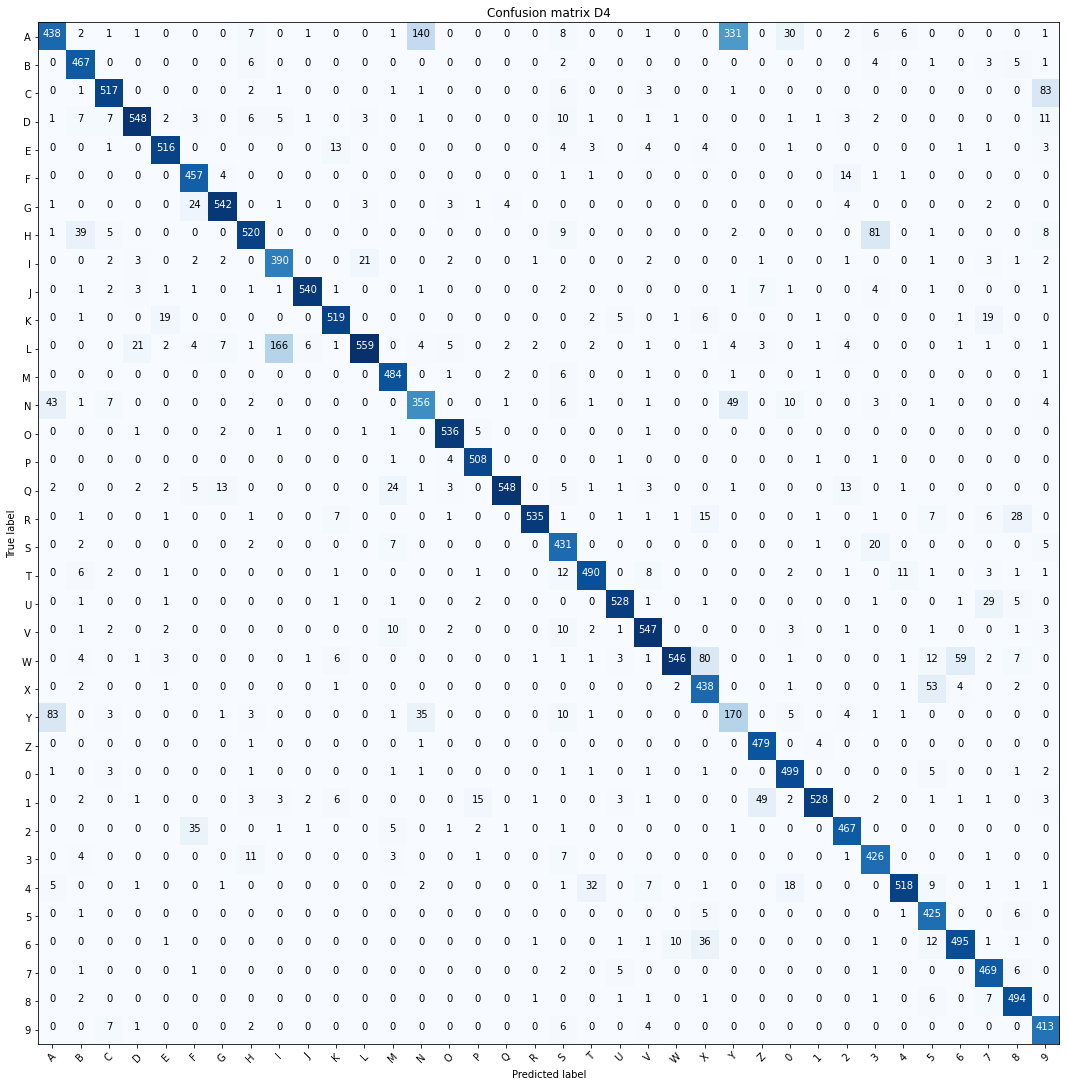

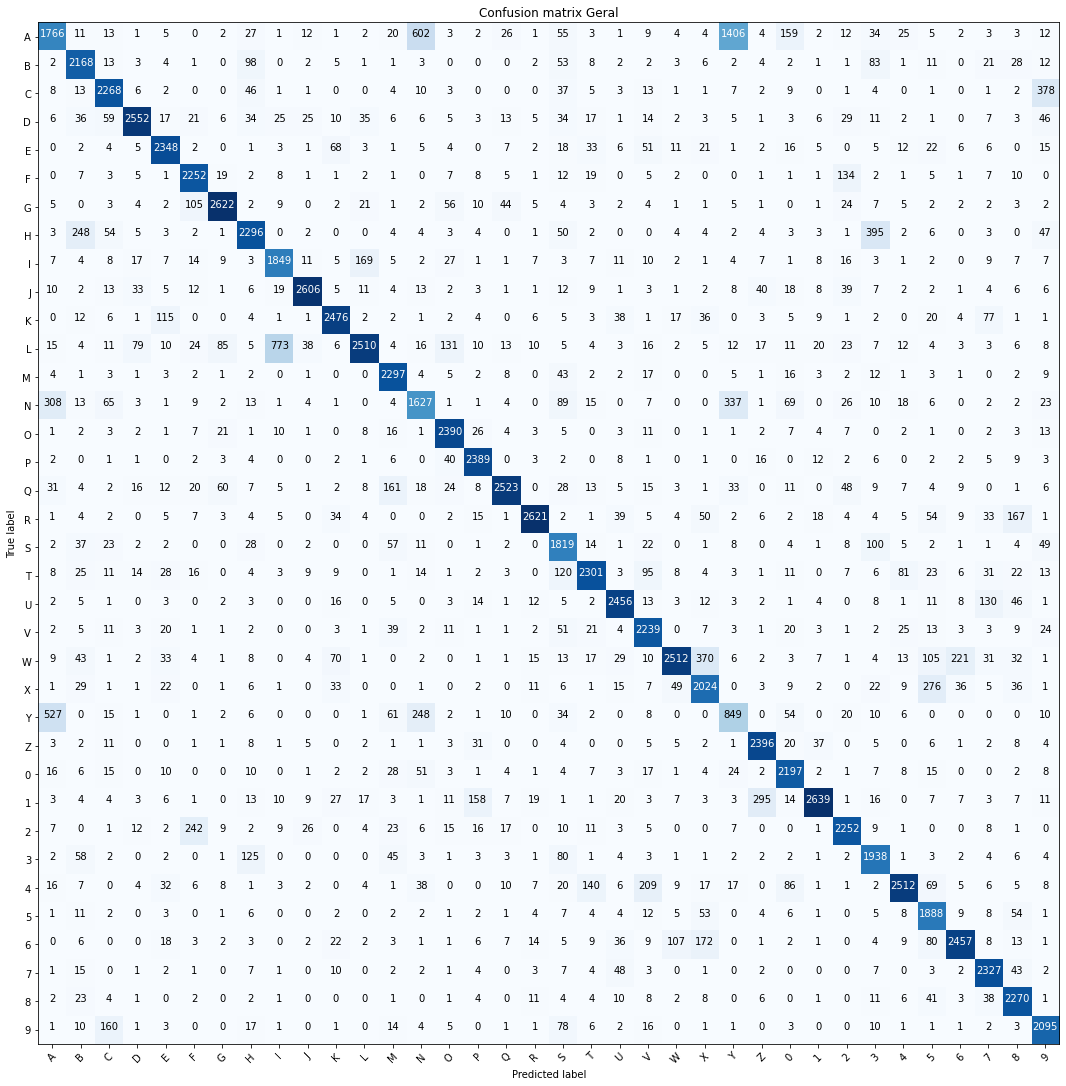

In [23]:
accuracy, d_accuracy = metrics(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]], net_random)

In [24]:
print ("Accuracy on test data is: %0.2f, acc_d1= %0.2f, acc_d2= %0.2f, acc_d3= %0.2f, acc_d4= %0.2f, acc_d5= %0.2f"%(accuracy, d_accuracy[0], d_accuracy[1], d_accuracy[2], d_accuracy[3], d_accuracy[4]))

Accuracy on test data is: 0.81, acc_d1= 0.87, acc_d2= 0.77, acc_d3= 0.75, acc_d4= 0.79, acc_d5= 0.87


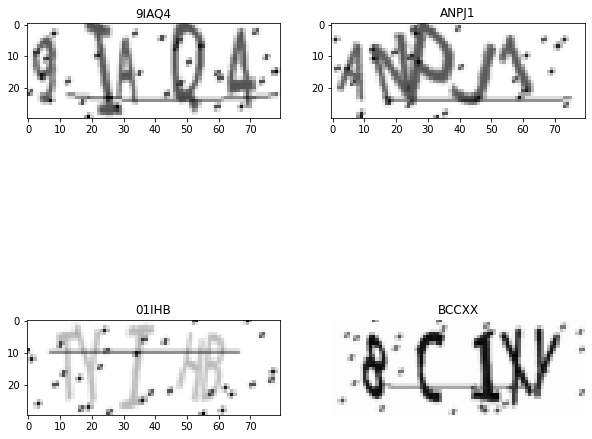

In [25]:
# Exemplo de predição
predict_sample(net_random);

### 5.2.2 - Modelo permutação

In [26]:
################################################################################################################
#
# Avalia modelo Permutação
#
################################################################################################################

net_perm.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])

19976/19976 [==============================] - 5s 243us/step


[4.733513394211787,
 0.666046679019928,
 1.0763729810714722,
 1.1855565309524536,
 1.03109610080719,
 0.7731929421424866,
 0.7844913601875305,
 0.6840208172798157,
 0.663496196269989,
 0.6920804977416992,
 0.7685222029685974]

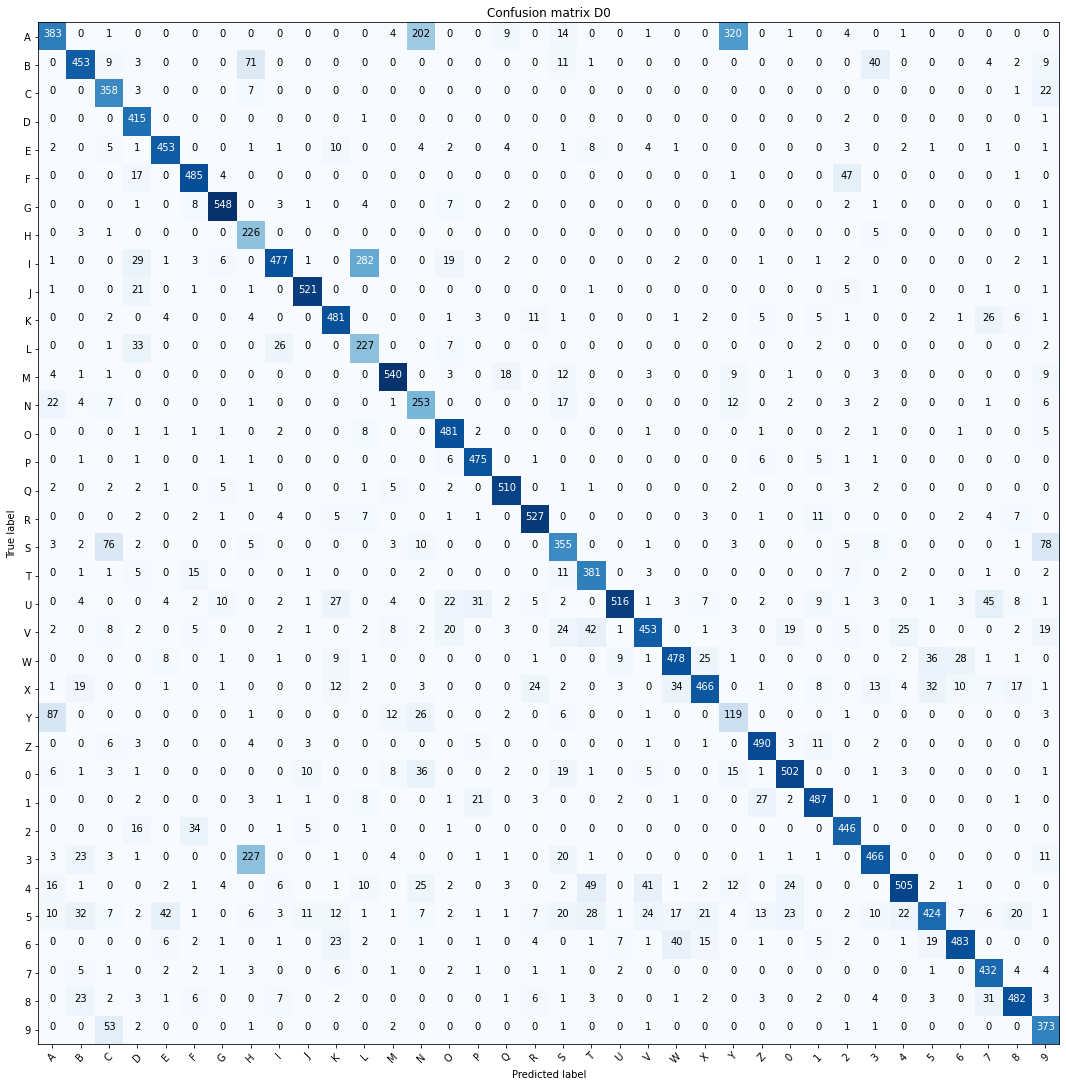

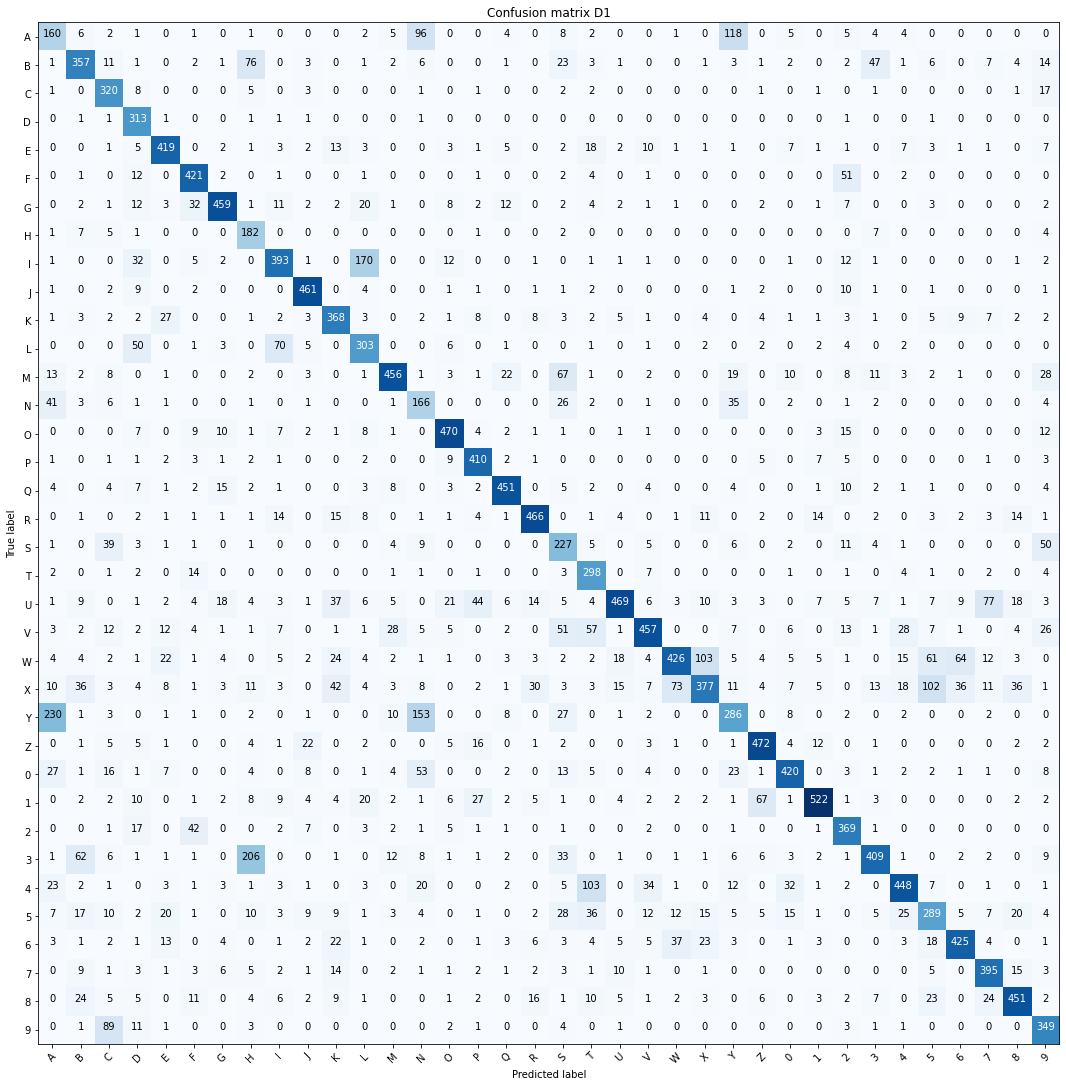

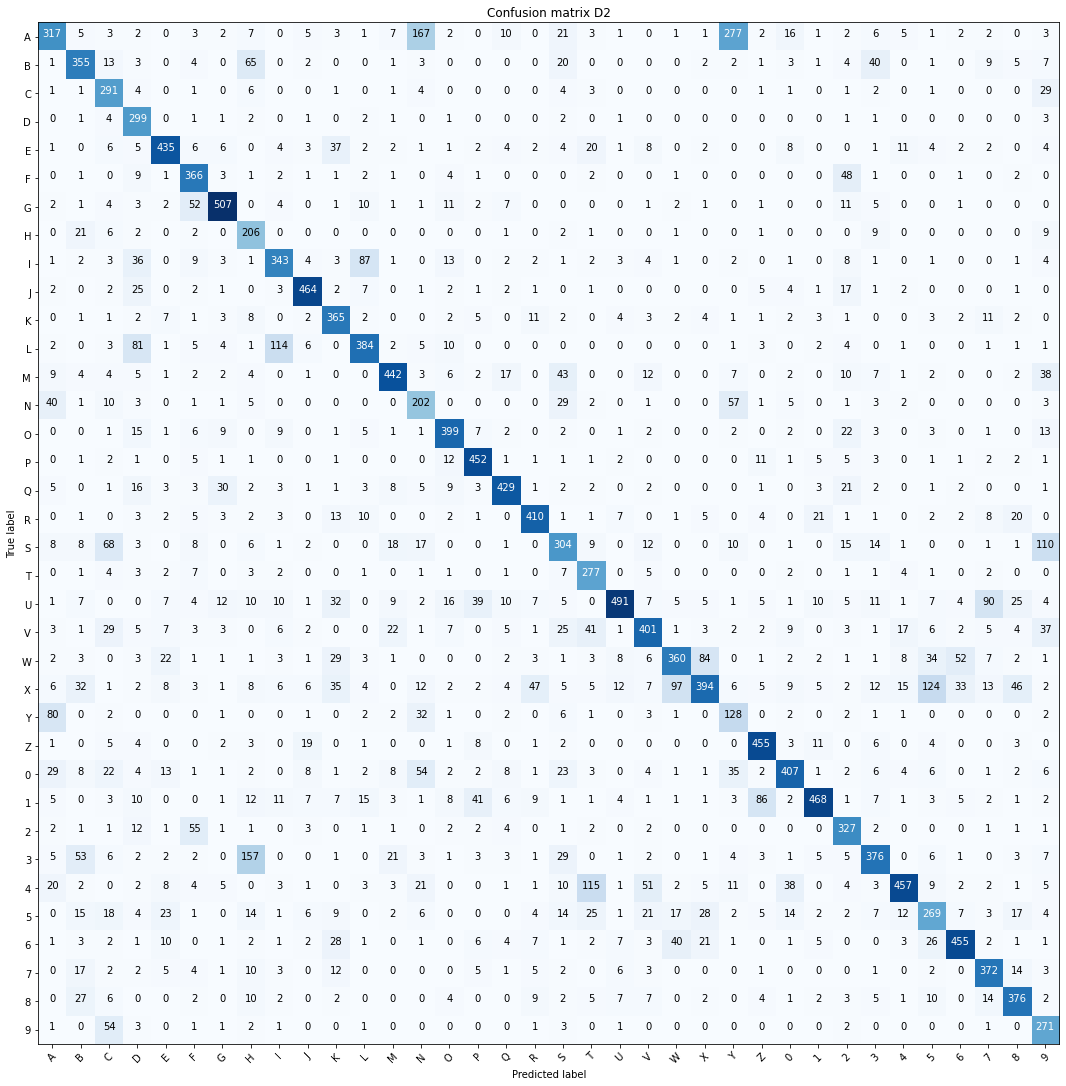

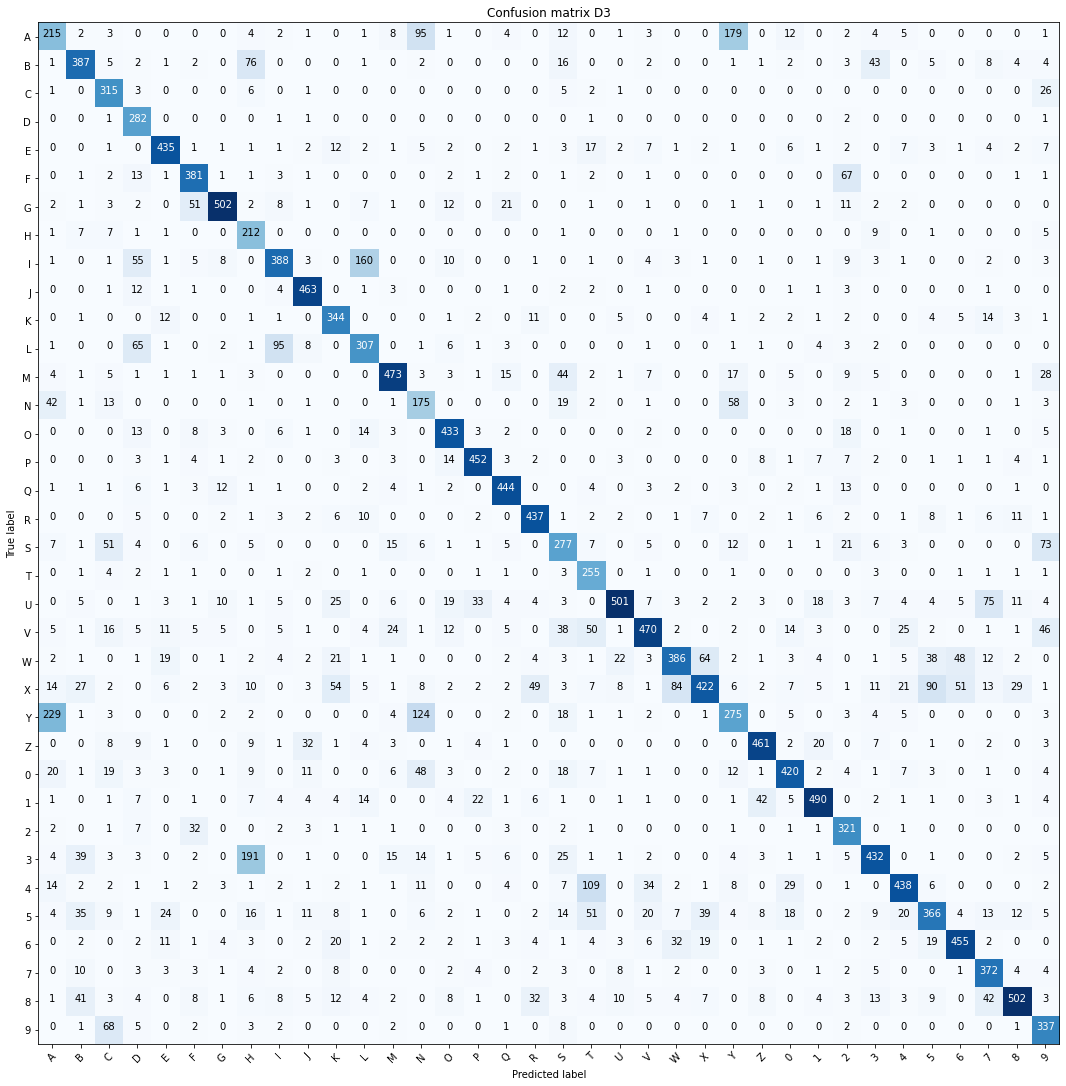

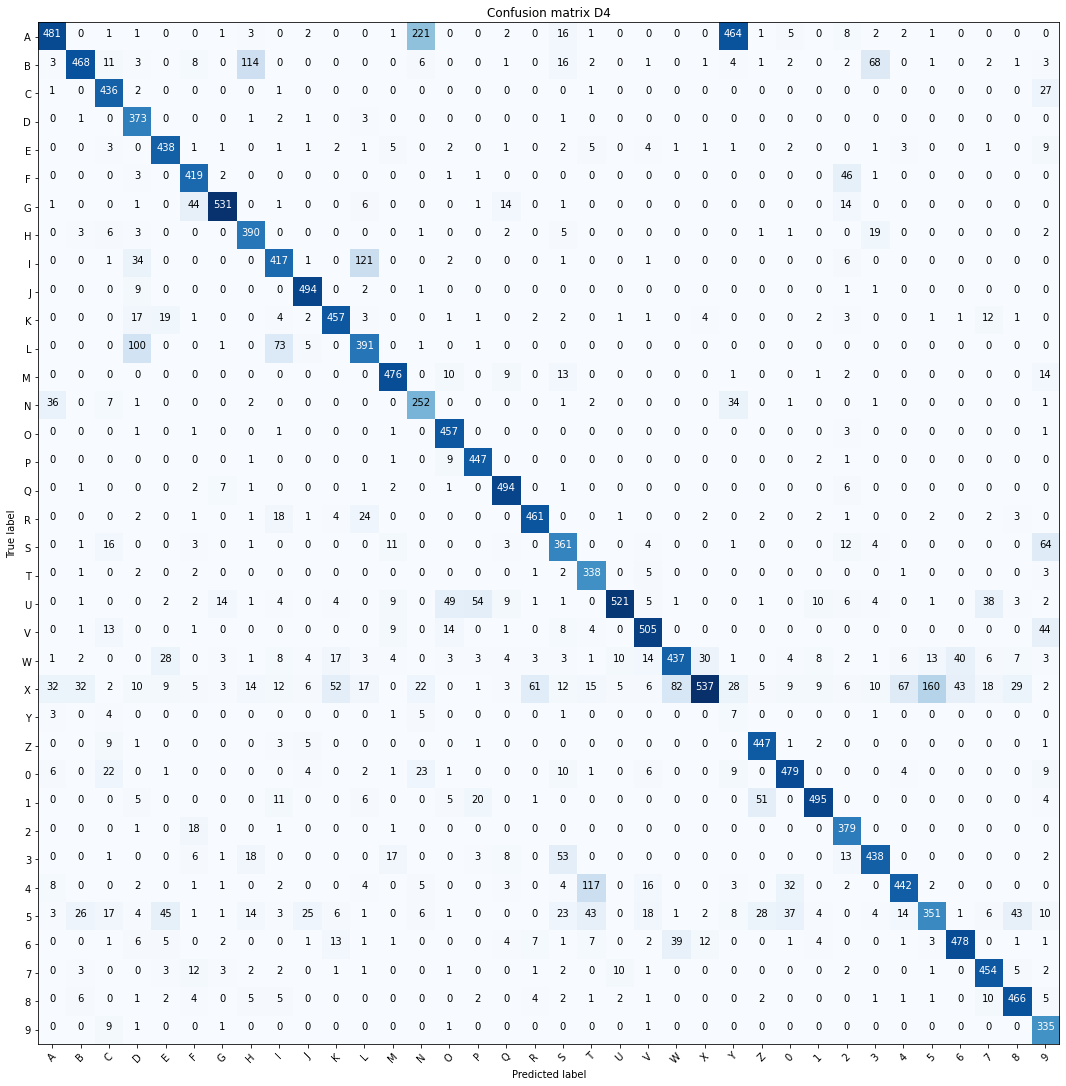

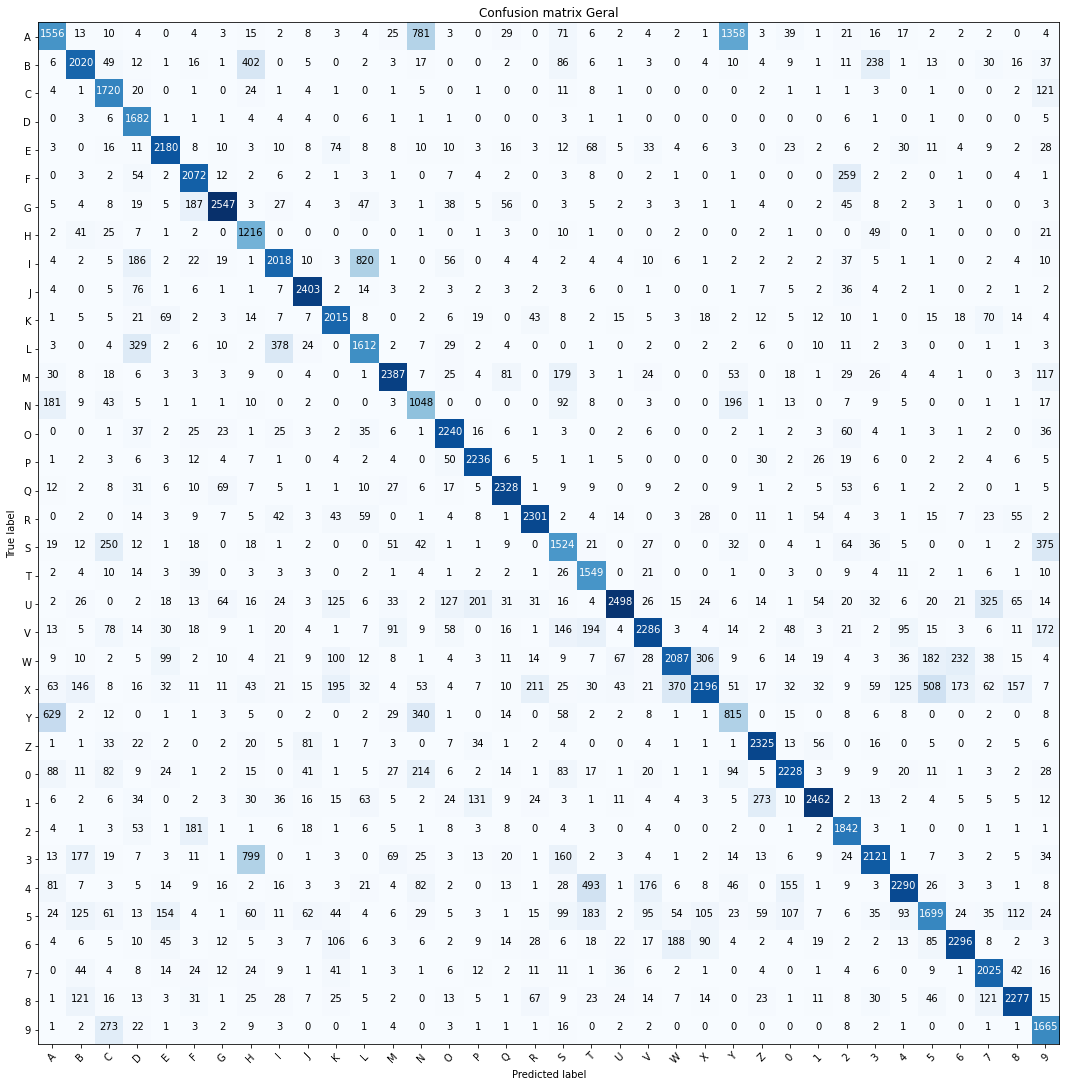

In [27]:
accuracy, d_accuracy = metrics(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]], net_perm)

In [28]:
print ("Accuracy on test data is: %0.2f, acc_d1= %0.2f, acc_d2= %0.2f, acc_d3= %0.2f, acc_d4= %0.2f, acc_d5= %0.2f"%(accuracy, d_accuracy[0], d_accuracy[1], d_accuracy[2], d_accuracy[3], d_accuracy[4]))

Accuracy on test data is: 0.72, acc_d1= 0.78, acc_d2= 0.68, acc_d3= 0.66, acc_d4= 0.69, acc_d5= 0.77


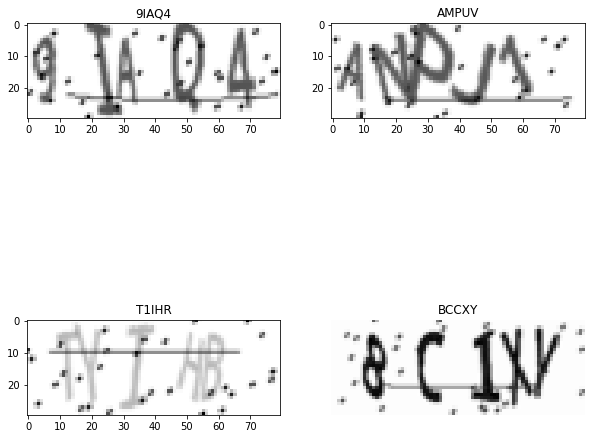

In [29]:
# Exemplo de predição
predict_sample(net_perm);